In [6]:
## Base computations for Bachelier problem
import numpy as np
import time
import os,sys
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ot
import ott
import numpy as np
from sklearn.neighbors import NearestNeighbors
import codpy.core as core
from codpy.kernel import Kernel
from codpy.multiscale_kernel import MultiScaleOT
from codpy.plot_utils import multi_plot
from codpy.file import files_indir
from codpy.clustering import GreedySearch
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from data_gen import *
os.environ["OMP_NUM_THREADS"] = "16"

In [7]:
def nn_estimation_rate(sampling_function, mapfnt, Ns, Ds, data, numTrials=10, N_sampling=10000, fun=None, method_name="COT"):
    
    L2_NN_Error = np.zeros((len(Ds), len(Ns), numTrials))
    times = {"data":[]}

    for k, d in enumerate(Ds):
        for i, n in enumerate(Ns):
            for t in range(numTrials):
                
                ### generate "training" data 
                source = sampling_function(n, d)
                source_ = sampling_function(n, d)
                target = mapfnt(source_)
                
                ### generate "L^2(P) estimation data" (out-of-sample points)
                source_mc = sampling_function(N_sampling, d)
                ot_t = mapfnt(source_mc)

                # Compute the transport using the specified method
                tic = time.time()
                tnn = fun(source_mc, source, target)
                toc = time.time()
                times['data'].append([d,n,numTrials,toc-tic])

                # Compute the L2 error
                L2_NN_Error[k, i, t] = (np.linalg.norm((tnn - ot_t), axis=1) ** 2).mean()

                if (t + 1) % numTrials == 0:
                    print('method:'+method_name,'d=%f, n=%d, trials: %d/%d, time=%f' % (d, n, t + 1, numTrials, toc-tic))

        print('==== Done with dimension %f ====' % d)

    # Include the method name in the output file name
    pkl_title = '{}_{}.pkl'.format(data, method_name)
    path = os.path.abspath('')
    pkl_title = os.path.join(path,pkl_title)
    
    # Save the results to a file
    dict_data = {
        'Ds': Ds,
        'N_sampling': N_sampling,
        'Ns': Ns,
        'numTrials': numTrials,
        'L2_NN_Error': L2_NN_Error,
        'data': data,
        'times': times
    }
    
    with open(pkl_title, 'wb') as output:
        pickle.dump(dict_data, output)
    
    return pkl_title

In [8]:
def compare_methods(files, Ds, Ns, data, save=False):

    colors = ['r', 'b', 'g','c','y']
    linestyles = ['solid','-', '--', '-.',':']

    def plot_MSE(id_d,ax=None,**kwargs):
        id,d = id_d[0], id_d[1]
        figsize = kwargs.get('figsize',(4, 4))
        if ax == None: fig, ax = plt.subplots(figsize=figsize)
        for method_id,file in enumerate(files):
            with open(file, 'rb') as f:
                file_data = pickle.load(f)

            l2_nn = file_data['L2_NN_Error']
            l2nn_d = l2_nn[id]

            file_name = os.path.splitext(os.path.basename(file))[0]

            ynn_means = np.mean(l2nn_d, axis=-1)
            ynn_std = np.std(l2nn_d, axis=-1)

            x_ = sm.add_constant(np.log(np.array(Ns)))
            modelnn = sm.OLS(np.log(ynn_means), x_).fit()
            print(f'{file_name}, d={d}, rate={modelnn.params[1]}')

            plt.plot(Ns, ynn_means, label=f'{file_name}', color=colors[method_id], linestyle=linestyles[method_id])
            plt.errorbar(Ns, ynn_means, yerr=ynn_std, color=colors[method_id], linestyle=linestyles[method_id])
            plt.title(kwargs.get("title",'d='+str(d)))
            plt.xlabel('$n$ samples')
            plt.ylabel('Mean Squared Error')

    def plot_time(id_d,ax=None,**kwargs):
        id,d = id_d[0], id_d[1]
        figsize = kwargs.get('figsize',(4, 4))
        if ax == None: fig, ax = plt.subplots(figsize=figsize)
        for method_id,file in enumerate(files):
            with open(file, 'rb') as f:
                file_data = pickle.load(f)

            l2_nn = pd.DataFrame(data = file_data['times']['data'], columns = ["D","N","K","times"])
            l2nn_d = (l2_nn[l2_nn["D"]==d]["times"]).to_numpy()
            l2nn_d = l2nn_d.reshape([len(Ns),int(l2nn_d.shape[0] / len(Ns))])

            file_name = os.path.splitext(os.path.basename(file))[0]

            ynn_means = np.mean(l2nn_d, axis=-1)
            ynn_std = np.std(l2nn_d, axis=-1)

            x_ = sm.add_constant(np.log(np.array(Ns)))
            modelnn = sm.OLS(np.log(ynn_means), x_).fit()
            print(f'{file_name}, d={d}, rate={modelnn.params[1]}')

            plt.plot(Ns, ynn_means, label=f'{file_name}', color=colors[method_id], linestyle=linestyles[method_id])
            plt.errorbar(Ns, ynn_means, yerr=ynn_std, color=colors[method_id], linestyle=linestyles[method_id])
            plt.title(kwargs.get("title",'d='+str(d)))
            plt.xlabel('$n$ samples')
            plt.ylabel('Execution Time')

    multi_plot(
        list(enumerate(Ds)),
        fun_plot=plot_MSE,
        mp_max_items=-1,
        mp_figsize=(14, 4))
    plt.legend()
    plt.show()
    if save: plt.savefig(f'Error_{data}.pdf')

    multi_plot(
        list(enumerate(Ds)),
        fun_plot=plot_time,
        mp_max_items=-1,
        mp_figsize=(14, 4))
    plt.legend()
    plt.show()
    if save: plt.savefig(f'Time_{data}.pdf')

In [9]:
#### 1-Nearest Neighbor Estimator
def LoopThruG(G,n,thr=1e-8):
  l1 = []
  l2 = []
  mx = G.max()
  for i in range(n):
    l1.append(i)
    for j in range(n):
      if G[i, j] / mx > thr:
        l2.append(j)
  return dict(zip(l1,l2))

def OT_0(source,target,a=None,b=None,maxiters=1000000):
    n = source.shape[0]
    if a == None:
        a = np.ones(n,)/n
    if b == None:
        b = np.ones(n,)/n
    M = ot.dist(source,target)
    G0 = ot.emd(a,b,M,numItermax=maxiters)
    return G0

def NNEstimator(x,source,target,G0,algo='brute'):
    nbrs = NearestNeighbors(n_neighbors=1, algorithm=algo).fit(source)
    _, indices = nbrs.kneighbors(x)

    #target_1nn = np.zeros((len(indices),dim))
    target_1nn = np.zeros_like(x)
    loopG = LoopThruG(G0,len(G0))
    for i, e in enumerate(indices):
      ind_ = loopG[int(e)]
      target_1nn[i] = target[ind_]

    return target_1nn

def POT(x,source,target):
    G0 = OT_0(source,target)
    return NNEstimator(x,source,target,G0)

def COT(x,source,target):
    # core.set_num_threads(1)
    return Kernel(set_kernel=core.kernel_setter("maternnorm","standardmean",0,1e-9)).map(source,target,distance="norm22")(x)

def COT_parallel(x,source,target):
    return Kernel(set_kernel=core.kernel_setter("maternnorm","standardmean",0,1e-9)).map(source,target,distance="norm22",sub=True)(x)

def COT_MS(x,source,target):
    val = (int) (source.shape[0] / 512)
    return MultiScaleOT(N= val,set_kernel=core.kernel_setter("maternnorm","standardmean",0,1e-9),method = GreedySearch).set(source,target,distance="norm22",sub=True)(x)

def OTT(source_mc, source, target, epsilon=None, max_iters=1000):
    
    # the point cloud geometry
    if epsilon is None:
       geom = pointcloud.PointCloud(source, target)
    else:
      geom = pointcloud.PointCloud(source, target, epsilon = epsilon)
    
    # solution of the OT problem
    problem = linear_problem.LinearProblem(geom)
    output = sinkhorn.Sinkhorn(max_iterations=max_iters)(problem)
    
    dual_potentials = output.to_dual_potentials()

    # transport_map#(out-of-sample points)
    transported_points = dual_potentials.transport(source_mc)
    
    return transported_points

map_COT, d=2, rate=-0.8882520616809388
map_COT_MS, d=2, rate=0.31520707048032454
map_d_COT, d=2, rate=-0.9845406922025186
map_OTT, d=2, rate=-0.7976206220038263
map_POT, d=2, rate=-0.9555449221114991
map_COT, d=10, rate=-0.40258534053987793
map_COT_MS, d=10, rate=-0.09463924137152169
map_d_COT, d=10, rate=-0.37458370959073584
map_OTT, d=10, rate=-0.2897480249333956
map_POT, d=10, rate=-0.19043928803310484
map_COT, d=100, rate=-0.13961392893340374
map_COT_MS, d=100, rate=-0.04457914371426486
map_d_COT, d=100, rate=-0.12221098628499338
map_OTT, d=100, rate=-0.004877969849433672
map_POT, d=100, rate=-0.018033439706652388


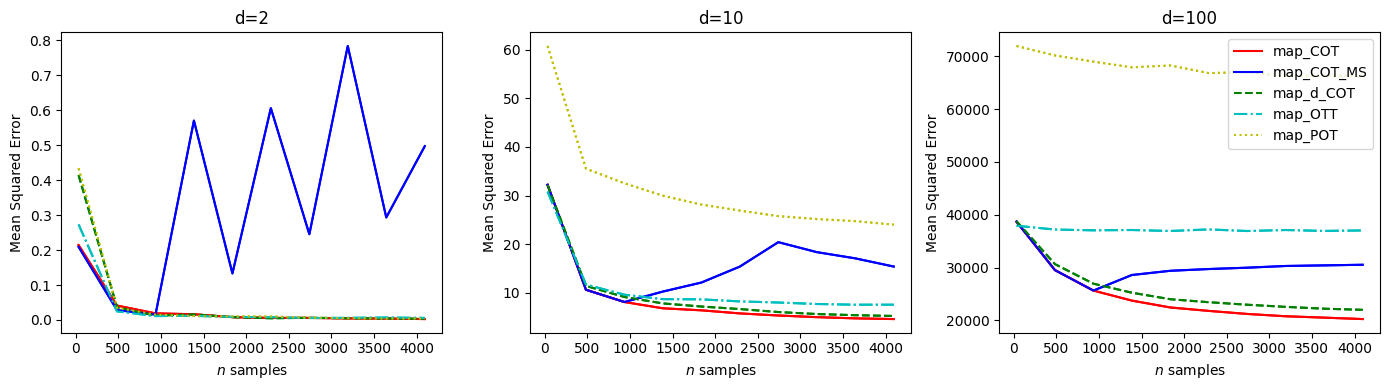

map_COT, d=2, rate=1.7173115494068414
map_COT_MS, d=2, rate=0.7119321379152783
map_d_COT, d=2, rate=1.3267106435250644
map_OTT, d=2, rate=0.09439008318717218
map_POT, d=2, rate=0.44197074407128545
map_COT, d=10, rate=1.7668769345660296
map_COT_MS, d=10, rate=1.1612774244127875
map_d_COT, d=10, rate=1.2849875983105772
map_OTT, d=10, rate=0.16660719220597942
map_POT, d=10, rate=0.5409340845866881
map_COT, d=100, rate=1.4354729768409624
map_COT_MS, d=100, rate=0.8589780829233651
map_d_COT, d=100, rate=0.9011525361507994
map_OTT, d=100, rate=0.16393470264385937
map_POT, d=100, rate=0.5252706148424291


<Figure size 640x480 with 0 Axes>

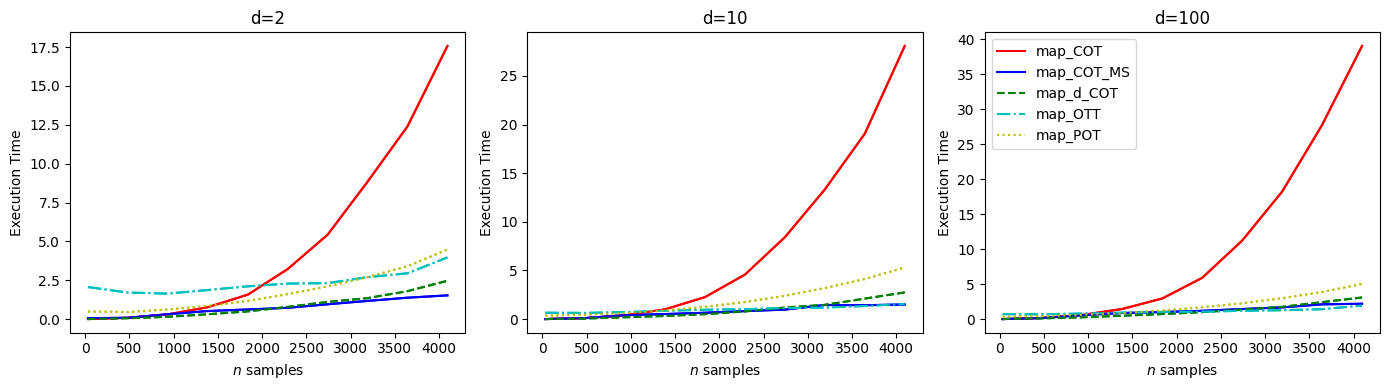

<Figure size 640x480 with 0 Axes>

In [10]:
Ds = [2,10,100]
Ns = np.linspace(32, 4096, num=10, dtype=int)
data = 'map'

# file_COT_MS = nn_estimation_rate(sample_uniform, OT_map, Ns, Ds, data=data, fun=COT_MS, method_name="COT_MS",numTrials=1)
# file_POT = nn_estimation_rate(sample_uniform, OT_map, Ns, Ds, data=data, fun=POT, method_name="POT",numTrials=1)
# file_COT = nn_estimation_rate(sample_uniform, OT_map, Ns, Ds, data=data, fun=COT,  method_name="COT",numTrials=1)
# file_COT_parallel = nn_estimation_rate(sample_uniform, OT_map, Ns, Ds, data=data, fun=COT_parallel,  method_name="d_COT",numTrials=1)
# file_OTT = nn_estimation_rate(sample_uniform, OT_map, Ns, Ds, data=data, fun=OTT, method_name="OTT",numTrials=1)

path = os.path.abspath('')
files = files_indir(path,".pkl")
compare_methods(
    files=files,
    Ds=Ds,
    Ns=Ns,
    data=data,
    save=True
)
pass